In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
atlasAlignOptLogs_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignOptLogs'

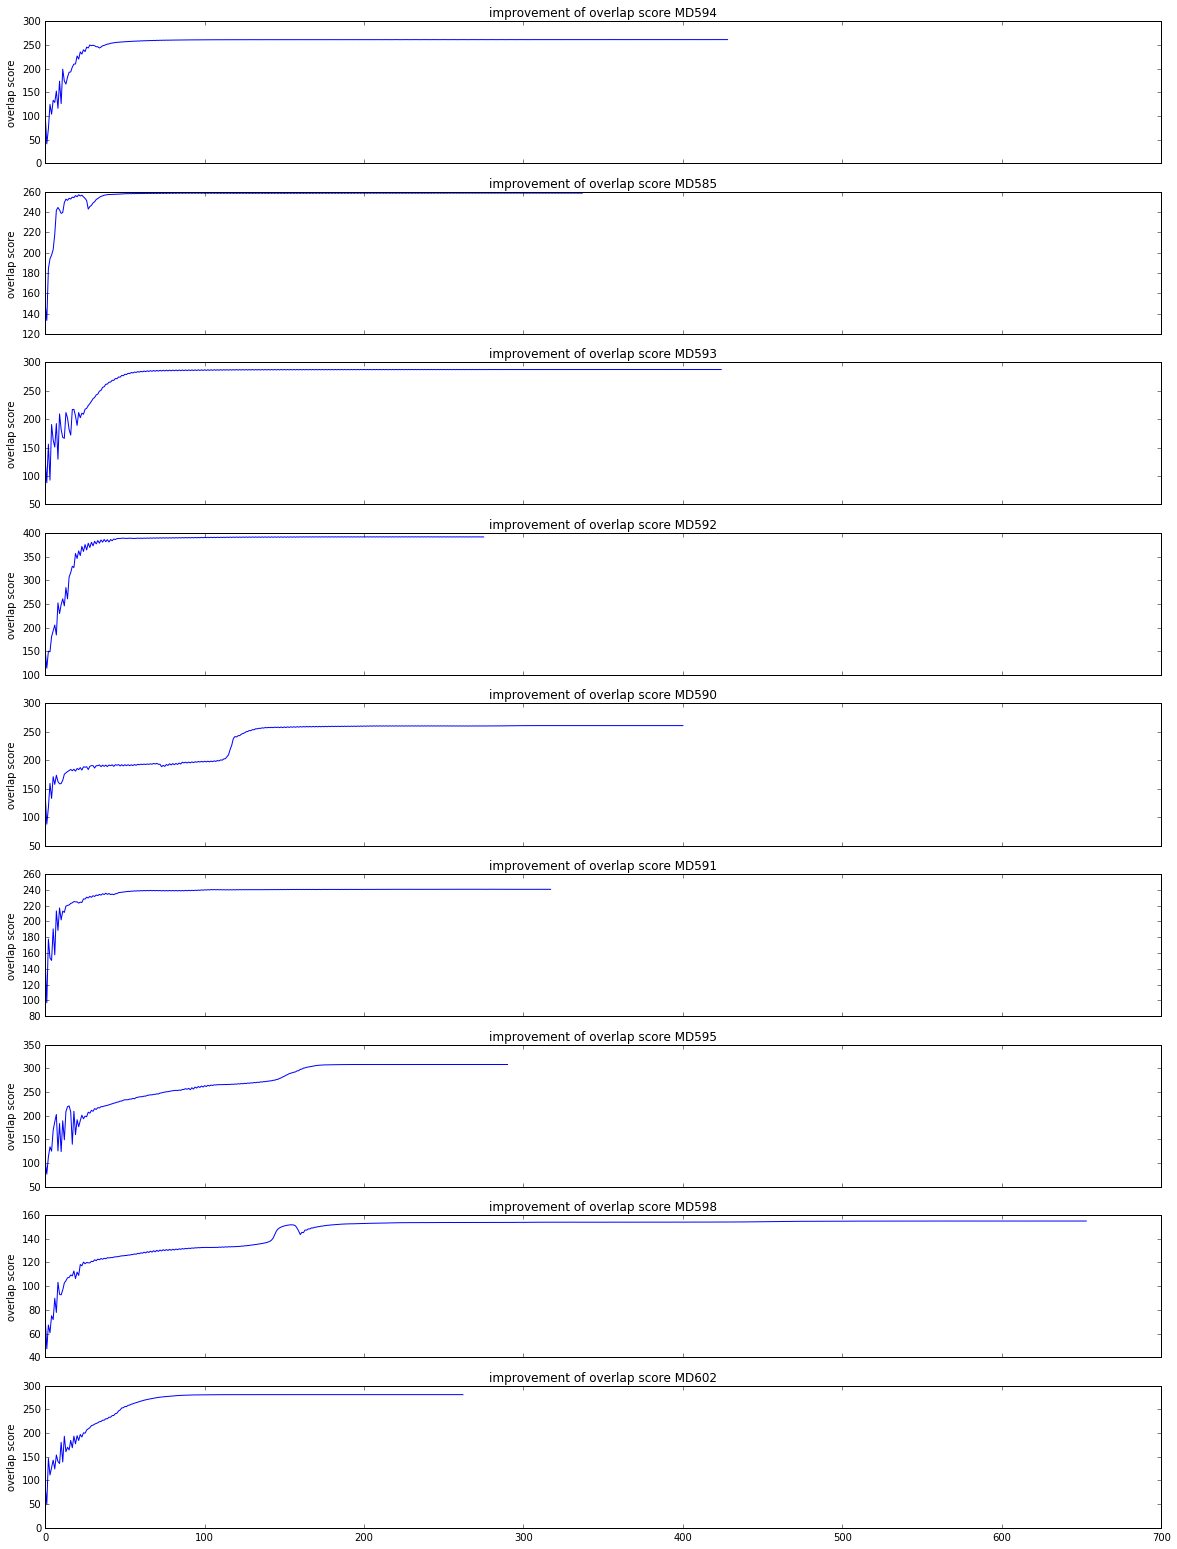

In [61]:
fig, axes = plt.subplots(9, 1, figsize=(20, 5*9), squeeze=True, sharex=True)

for i, stack in enumerate(['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']):

# stack = 'MD590'

    scores = np.load(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack})

    axes[i].plot(scores[:]);
    axes[i].set_title('improvement of overlap score %s' % stack);
#     axes[i].set_xlabel('iteration');
    axes[i].set_ylabel('overlap score');

plt.show();

In [53]:
history_len = 50

ds = []
for i in range(len(scores)):
    s = scores[i]
    d = np.abs(np.mean(scores[i-history_len:i]) - np.mean(scores[i-2*history_len:i-history_len]))
    ds.append(d)
    if d < .1:
        print 'break'
        break
print i

break
386


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in absolute


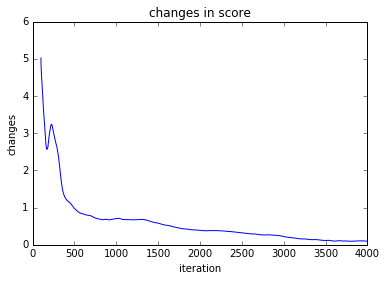

In [147]:
plt.plot(ds);
plt.title('changes in score');
plt.xlabel('iteration');
plt.ylabel('changes');
plt.show();

In [62]:
stack = 'MD594'

In [64]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

from registration_utilities import *

In [66]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

In [71]:
################# LOAD TEST VOLUME ######################

section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

global volume2_allLabels
volume2_allLabels = []

for l in labels[1:]:

    print l

    volume2 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_%(label)s.bp' % \
                                                  {'stack': stack, 'label': l}))

    volume2_cropped = volume2[volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1]
    # copy is important, because then you can delete the large array

    volume2_allLabels.append(volume2_cropped.copy())

    del volume2, volume2_cropped

test_ydim, test_xdim, test_zdim = volume2_allLabels[0].shape
test_centroid = (.5*test_xdim, .5*test_ydim, .5*test_ydim)
test_cx, test_cy, test_cz = test_centroid

print test_xdim, test_ydim, test_zdim
print test_centroid

93 364
5N
7n
7N
12N
Pn
VLL
6N
Amb
R
Tz
RtTg


KeyboardInterrupt: 

In [67]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [68]:
volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))
atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
print atlas_xdim, atlas_ydim, atlas_zdim

810 405 534


In [69]:
def parallel_where(l):
    w = np.where(volume1 == l)
    return [w[1], w[0], w[2]]

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

print time.time() - t, 'seconds'

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax

atlas_centroid = np.array([.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax])
print atlas_centroid

atlas_cx, atlas_cy, atlas_cz = atlas_centroid

2.31593513489 seconds
0 809 0 404 0 533
[ 404.5  202.   266.5]


In [70]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled